In [ ]:
# Step-by-step guide to implement the model of self-organized criticality by Levina et al. (2007) with the network simulator brian2

We implement a model of dynamical synapses that is governed by Equation (1):
\begin{align} \dot h_i = \delta_{i,\xi_{\tau(t)}} I^{ext} + \frac{1}{N} \sum_{j=1}^N u J_{ij} \delta(t-t_{sp}^j\tau_d) \\
\dot J_{ij} = \frac{1}{\tau_j} (\frac{\alpha}{u}-J_{ij})-uJ_{ij}\delta(t-t_{sp}^j)
\end{align}

In [1]:
from brian2 import *
import numpy as np
import pandas as pd
import os

#set the random seed for reproducability
np.random.seed(1)

First, we initialise all variables of the model. Here we use a network of only 3 Neurons as a toy model.

In [3]:
N=3
alpha = 1.4
u = 0.2
nu = 10
I = 0.025
theta = 1

We need to specify temporal variables in physical units, but for other variables of the model, such as the membrane potential h, we omitted physical units. First, we specify the timescales by obeying $\tau_d \ll \tau$


In [4]:
tau = 10*ms
tau_d = 1*ms

Next, we specify the duration of the simulation in milliseconds and set the temporal resolution of the Numerical solver used by brian2 to the same amount of the timescale $\tau$. This makes the system discrete, e.g. with $10.000 ms$ and a timescale of $\tau=10ms$, the system is simulated for 1000 steps.

In [5]:
duration = 1000*ms 
#sets the timestep to tau which makes the model discrete
dt = tau

Typically the dynamics of the model are passed to brian2 by a literal. The dynamics of the membrane potential are however solely event-based, e.g. spike-triggered or given by external drive. Thus, the specification of the membrane dynamics becomes trivial and we only need to introduce the variable h and specify that it doesn't have a physical unit.

In [6]:
eqs = "h:1"

The model of the membrane potential gets implemented by the Class NeuronGroup. We can specify the threshold $\theta = 1$ and a reset action that decreases $h_i$ by the amount $\theta$, when the threshold is reached.

In [7]:
G = NeuronGroup(N, eqs, threshold = 'h>=theta', reset = 'h -= theta', method = 'euler', dt = dt)

#initialise mebrane potentials with some arbitrary values
G.h = [0,0.3,0.9]

Next, we implement the external input that is governed by the process $\xi_{\tau}(t)$, which selects every $\tau$ timesteps uniformly one Neuron in the network and increases it's membrane potential by the amount $I^{ext}$. We can implement this using the class NetworkOperation.

In [8]:
#gets called by the brian2 NetworkOperation class, implements the external drive
def external_input():
    idx = np.random.randint(N)
    G.h[idx]+=I

#this calls the external input every tau steps
net_op = NetworkOperation(external_input, dt= tau)

Now we will implement the dynamics of the synaptic stength. First we specify the timescale $\tau_j = \tau \nu N$, obeying $\nu \ll N$.

In [9]:
#calculate the time-scale of the dynamics of the synaptic strength
tau_j = tau*nu*N
J_max = alpha/u

The dynamics of the synpatic strength as given in Equation (1) are separated by a minus sign. The first part only depends on time, driving $J_{ij}$ back to it's maximum $\frac{\alpha}{u}$. And the spike-triggered part, reducing $J_{ij}$ by the fraction $u$ after a presynaptic spike. We specify the first part in the variable $\text{eqs}$, that is $\dot J_{ij} = \frac{1}{\tau_j} (\frac{\alpha}{u}-J_{ij})$ and pass it as the model specification to the Synapses class of brian2.
The spike-triggered part can be implemented as part of the $\text{on_pre}$ statement of the Synapses class, which gets executed upon a presynaptic spike. Two actions need to be performed upon a presynaptic spikes. The first, which is specified in the $\text{pre_transmission}$ pathway, increases the postsynaptic membrane potential by the amount $\frac{u}{N}J_{ij}$. The second is specified in the $\text{pre_selforg}$ pathway. It decreases $J_{ij}$ by the fraction u.
The decrement of the synaptic strength at spike time needs to be adjusted with a correction term, as the governing ODE gets updated first within brian2. Thus, we cannot simply write $J-=u*J$. As in this case J has already been updated internally.
The correction term can be easily derived:
We denote $J^+$ as the synaptic strength after the update of the time-dependent part, that is:
\begin{align}
    J^+ = J_{ij}(t_{sp}^j)+1/\tau_j(\frac{\alpha}{u} - J_{ij}(t_{sp}^j))
\end{align}
To obtain the synaptic strength at spike time in the presynaptic neuron, we simply solve the above equation for $J_{ij}(t_{sp}^j)$ and obtain
\begin{align}
J_{ij}(t_{sp}^j) = \frac{J^+ - \frac{\alpha}{\tau_j u}}{1-\frac{1}{\tau_j}}.
\end{align}We then apply the decrement by fraction $u$ to the above term.


In [10]:
N_neurons = N #we have to rename N because the class Synapses uses this variable internally, too

#time-dependent part
eqs =  "dJ/dt = 1/tau_j*(alpha/u-J) : 1"

S = Synapses(G,G, eqs, on_pre = {'pre_transmission': 'h_post += u/N_neurons*J',
                                 'pre_selforg': 'J = clip(J-u*((J-alpha/(tau_j/ms*u))/(1-1/(tau_j/ms))), 0, J_max)'}, dt = dt, method = 'euler')

#connect the Neurons to construct a fully connected network without recursive links                                                                          
S.connect(condition = 'i!=j')

#initialise synaptic strength uniformly on [0,J_max]
S.J = np.random.uniform(0,J_max, size = S.J.shape[0])

#specify the synaptic timescale that affects the membrane potential dynamics
S.pre_transmission.delay = tau_d

#specify the monitors which are later used for plotting
spikes = SpikeMonitor(G)
neuron_state = StateMonitor(G, 'h', dt = dt, record = True)
synapse_state = StateMonitor(S, 'J', dt=dt, record = True)


INFO       The synaptic equation for the variable J does not specify whether it should be integrated at every timestep ('clock-driven') or only at spiking events ('event-driven'). It will be integrated at every timestep which can slow down your simulation unnecessarily if you only need the values of this variable whenever a spike occurs. Specify the equation as clock-driven explicitly to avoid this warning. [brian2.synapses.synapses.clock_driven]


Finally we can run the model

In [11]:
print('Running simulation...')
run(duration)
print('Done')


WARNING    'dt' is an internal variable of group 'synapses', but also exists in the run namespace with the value 10. * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Running simulation...
Done


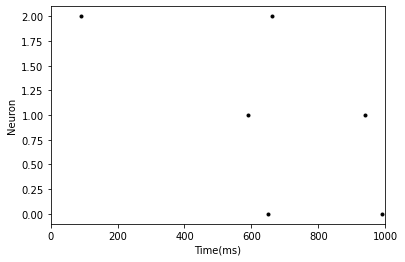

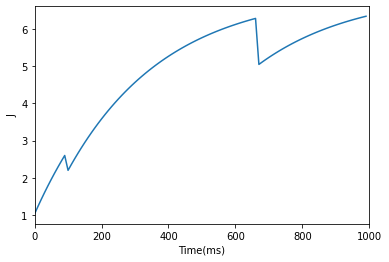

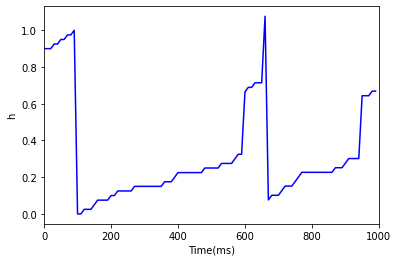

In [12]:
#plot a raster plot, the evolution of the synaptic strength of an exemplary synapse and the trace of the corresponding presynaptic neuron
plt.plot((spikes.t/ms), spikes.i, '.k')
plt.xlim(0, duration/ms)
plt.xlabel('Time(ms)')
plt.ylabel('Neuron')
plt.show()

plt.plot(synapse_state.t/ms, synapse_state.J[4])
plt.xlim(0, duration/ms)
plt.xlabel('Time(ms)')
plt.ylabel('J')
plt.show()

plt.plot(neuron_state.t/ms, neuron_state.h[2], '-b')
plt.xlabel('Time(ms)')
plt.xlim(0, duration/ms)
plt.ylabel('h')
plt.show()